# Problem Set 5, due Nov 13 at 11:59pm.

As usual, you are highly encouraged to start this problem set early.  You have considerable flexibility in how creative you wish to be with this problem set.

## Part 1: Exploring the Titanic

Your mission for this problem set is to use your knowledge of supervised machine learning to try to predict which passengers aboard the Titanic were most likely to survive. The prompts for this part of the problem set are deliberately vague - the goal is to leave it up to you how to structure (most of) your analysis.

To get started, read about the prediction problem on [Kaggle](https://www.kaggle.com/c/titanic). Then, download the data [here](https://www.kaggle.com/c/titanic/data) - you'll want at least the train and test data, maybe more.

### 1.1 Exploratory data analysis

Create 2-3 figures and tables that help give you a feel for the data. Make sure to at least check the data type of each variable, to understand which variables have missing observations (and to formulate a plan for dealing with them), and to understand the distribution of each variable (and determine whether the variables should be normalized or not). Are any variables collinear or highly correlated?

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt  

path = os.getcwd() 

# assign types to save memory
titanic = pd.read_csv(path+'/train.csv', dtype={
        'PassengerId': np.uint16, 
        'Survived': np.uint8,
        'Pclass': 'category', 
        'Name': 'category', 
        'Sex': 'category', 
        'Age': np.float32, 
        'SibSp': np.uint8, 
        'Parch': np.uint8, 
        'Ticket': 'category', 
        'Fare': np.float32,
        'Cabin': 'category',
        'Embarked': 'category'
        })

# Check out the data
print('Size:', titanic.shape)
print(titanic.isnull().sum()) # count NaNs



Size: (891, 12)
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


## Missing Data and Adding Features
There are a fair number of missing data points to consider and possibly more features to create. I have done the following in the next section:

1. Parse names into titles, first and last.
2. Calculated the size of families
3. Assigned a family role to each passenger (alone, child, mother, father, wife (no kids), husband (no kids))
4. Guessed missing age values by first looking to see if I can guess a child's age by their siblings' ages otherwise assigned them the average age of passengers who share the same title
5. I assigned the two missing ports as 'S' as it is the most common port of departure

Lastly, I dropped cabin assignments as there are far too many missing

In [2]:
# Create more features

# Create first, last, title names
titanic = titanic.sort_values('Name').reset_index()
titanic['LastName'], titanic['FirstName'] = titanic['Name'].str.split(',', 1).str
titanic['Title'], titanic['FirstName'] = titanic['FirstName'].str.split('.', 1).str

# Create family sizes
titanic['FamilySize']=titanic['SibSp']+titanic['Parch']+1

# Fill in missing ages
avgby_family = titanic.groupby(['LastName','FamilySize', 'Title']).mean().reset_index()
avgby_title = titanic.groupby('Title').mean().reset_index()

# Guess age by checking for a family. If there's a family then be close to the age of those that share a title
# Otherwise set age to be the average age of those with the same title
def guess_age(data):
    if np.isnan(data['Age']):
        title = data['Title']
        lastname = data['LastName']
        familysize = data['FamilySize']
        age = avgby_family[(avgby_family['LastName']==lastname) & (avgby_family['FamilySize']==familysize)]['Age'].iloc[0]
        if np.isnan(age):
            age = np.round(avgby_title[avgby_title['Title']==' Mr']['Age'].iloc[0])
            return age
        else:
            return age 
    else:
        return data['Age']
titanic['Age'] = titanic.apply(guess_age, axis=1) 

# Label as mother, father, wife (no kids), husband (no kids), child, or traveling alone
def mother_father(data):
    if (data['Title']==' Mr') and (data['Parch'] > 1):
        return 'father'
    elif (data['Title']==' Mrs') and (data['Parch'] > 1):
        return 'mother'
    if (data['Title']==' Mr') and (data['SibSp'] == 1):
        return 'husband'
    elif (data['Title']==' Mrs') and (data['SibSp'] == 1):
        return 'wife'
    elif ((data['Title']==' Master') or (data['Title']==' Miss')) and (data['Age'] <= 18.0):
        return 'child'
    else:
        return 'alone'
titanic['family'] = titanic.apply(mother_father, axis=1)

# Most commonly embarked port was S, replace the two missing values
titanic['Embarked'].value_counts()
titanic['Embarked'] = titanic['Embarked'].fillna('S')

# Drop unwanted columns
titanic = titanic[['LastName', 'FirstName', 'Title', 'Pclass', 'Sex', 'Age', 'SibSp','Parch', 
                   'Ticket', 'Fare', 'Embarked','FamilySize', 'family', 'Survived']]

## Descriptive Statistics

Overall, there are 891 instances in this data set. The average age of passengers is 30 and most people came with at least one other person they knew. Howevr, babies as well as elderly were on board along with very large families. A person paid, on average, 32 dollars for their ticket, but some passengers paid over 500. 

It's also very useful to note that out of 891 passengers we have data for, only 64 survived. This means our dataset is rather imbalanced and we should account for this when we are reporting accuracy.

In [3]:
# Descriptive statistics
describe = titanic.describe(percentiles=[0.5])
describe.round(2)

,Age,SibSp,Parch,Fare,FamilySize,Survived
count,891.00,891.00,891.00,891.00,891.00,891.00
mean,30.14,0.52,0.38,32.20,1.90,0.38
std,13.11,1.10,0.81,49.69,1.61,0.49
min,0.42,0.00,0.00,0.00,1.00,0.00
50%,32.00,0.00,0.00,14.45,1.00,0.00
max,80.00,8.00,6.00,512.33,11.00,1.00


In [4]:
print('number of survivors out of 891 passengers:', sum(titanic['Survived']))

number of survivors out of 891 passengers: 342


Examining families closely, we see that a vast majority of travellers were alone and male. Most people came from Southampton and were in third class. However, wives with no children were most often seen in first class. Of the survivors, the majority of children and women survived. However, men in general did not fare well. For a full breakdown of correlations with detailed features, see question 1.2. There are other factors which are collinear such as title and sex. However these are not unexpected.

In [5]:
cat_vars = titanic[['Sex', 'Pclass', 'Embarked', 'family', 'Survived']]
cat_vars.groupby('family').describe()

Survived                                             
           count      mean       std  min  25%  50%  75%  max
family                                                       
alone      610.0  0.326230  0.469217  0.0  0.0  0.0  1.0  1.0
child       98.0  0.622449  0.487267  0.0  0.0  1.0  1.0  1.0
father      19.0  0.105263  0.315302  0.0  0.0  0.0  0.0  1.0
husband     76.0  0.197368  0.400657  0.0  0.0  0.0  0.0  1.0
mother      24.0  0.583333  0.503610  0.0  0.0  1.0  1.0  1.0
wife        64.0  0.796875  0.405505  0.0  1.0  1.0  1.0  1.0

## Correlations
Below, we see some correlate dated, primarily about family information. Quite obviously, the more siblings or spouses you have will increase familiy size. However, we also see that larger families tended to pay higher fare as well.

In [6]:
 titanic.drop(['Survived'], axis=1).corr()

,Age,SibSp,Parch,Fare,FamilySize
Age,1.000000,-0.227763,-0.190577,0.087330,-0.250877
SibSp,-0.227763,1.000000,0.414838,0.159651,0.890712
Parch,-0.190577,0.414838,1.000000,0.216225,0.783111
Fare,0.087330,0.159651,0.216225,1.000000,0.217138
FamilySize,-0.250877,0.890712,0.783111,0.217138,1.000000


## Exploratory Figures
Below, I have made some figures showing basic demographic data reflecting what was shown in the tables more clearly. Most of the passengers are men traveling alone roughly in their 30s.

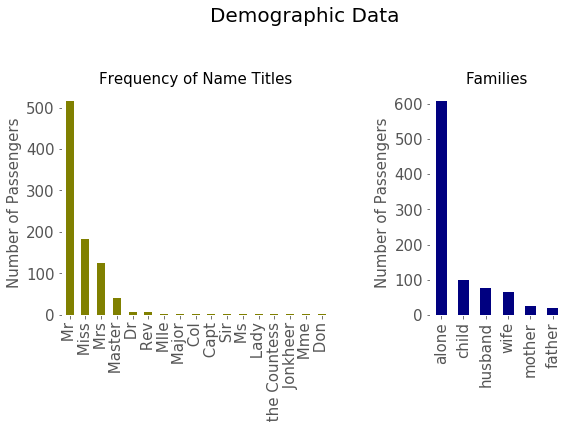

In [7]:
# Demographic Data
from matplotlib import gridspec

fig = plt.figure(figsize=(9,5))
fig.suptitle('Demographic Data', fontsize = 20)
plt.style.use('ggplot')

gs = gridspec.GridSpec(1, 2, width_ratios=[2,1], height_ratios=[1])
gs.update(wspace=0.5, hspace=0.5)

# Graph of Titles
ax0 = plt.subplot(gs[0])
ax0.set_facecolor('white')

ax0 = titanic['Title'].value_counts().plot.bar(color='olive')

ax0.set_title('Frequency of Name Titles', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.xlabel('Name Title', fontsize=15)
plt.ylabel('Number of Passengers', fontsize=15)

# Graph of family types
ax0 = plt.subplot(gs[1])
ax0.set_facecolor('white')

ax0 = titanic['family'].value_counts().plot.bar(color='navy')

ax0.set_title('Families', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of Passengers', fontsize=15)

plt.subplots_adjust(bottom = None, top = 0.75)
plt.show()

reference = titanic
titanic.to_csv('titanic_cleaned.csv')
# titanic.corr()

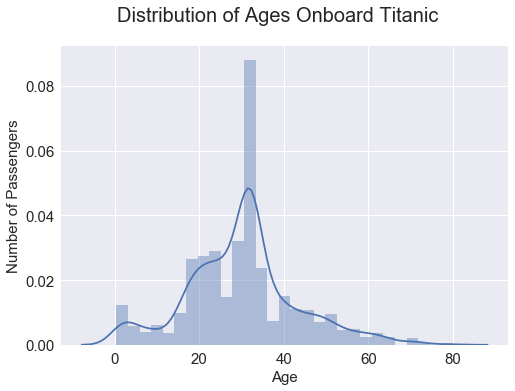

In [8]:
import seaborn as sns

sns.distplot(titanic['Age'])
plt.suptitle('Distribution of Ages Onboard Titanic', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Age', fontsize=15)
plt.ylabel('Number of Passengers', fontsize=15)

plt.show()

In [9]:
# Standardize  data
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

All the features included in the original data set are not necessarily useful. For example, first and Last names likely have little bearing on survivability. Below, I have selected the  features I think may reflect who did and did not survive and then one hot encoded all the categorical variables.

In [10]:
# Clean up data. One hot all categorical features.

titanic['Age'] = standardize(titanic['Age'])
titanic['SibSp'] = standardize(titanic['SibSp'])
titanic['Parch'] = standardize(titanic['Parch'])
titanic['Fare'] =  standardize(titanic['Fare'])
titanic['FamilySize'] =  standardize(titanic['FamilySize'])

# clean up white spaces in the names (not that it matters), take only the instances with more than 2 occurrences
titanic['Title'] = titanic['Title'].str.strip()
titles = list(titanic['Title'].unique())

# one hot encode the titles
titanic = pd.concat([titanic, pd.get_dummies(titanic['Title'])], axis=1)
# One hot encode all other categories.
titanic = pd.concat([titanic, pd.get_dummies(titanic['Pclass'])], axis=1)
titanic = pd.concat([titanic, pd.get_dummies(titanic['Sex'])], axis=1)
titanic = pd.concat([titanic, pd.get_dummies(titanic['family'])], axis=1)

titanic = titanic.drop(['Title', 'Pclass', 'Sex', 'family', 'LastName', 
                        'FirstName', 'Ticket', 'Embarked'], axis=1)

titanic = titanic[['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Capt',
       'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master', 'Miss',
       'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the Countess', '1',
       '2', '3', 'female', 'male', 'alone', 'child', 'father', 'husband',
       'mother', 'wife', 'Survived']]
titanic.columns = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Capt',
       'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master', 'Miss',
       'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the Countess', 'class1',
       'class2', 'class3', 'female', 'male', 'alone', 'child', 'father', 'husband',
       'mother', 'wife', 'Survived']
feature_names  = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Capt',
       'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master', 'Miss',
       'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the Countess', 'class1',
       'class2', 'class3', 'female', 'male', 'alone', 'child', 'father', 'husband',
       'mother', 'wife']


### 1.2 Correlates of survival

Use whatever methods you can think of to try and figure out what factors seem to determine whether or not a person would survive the sinking of the Titanic. What do you conclude?

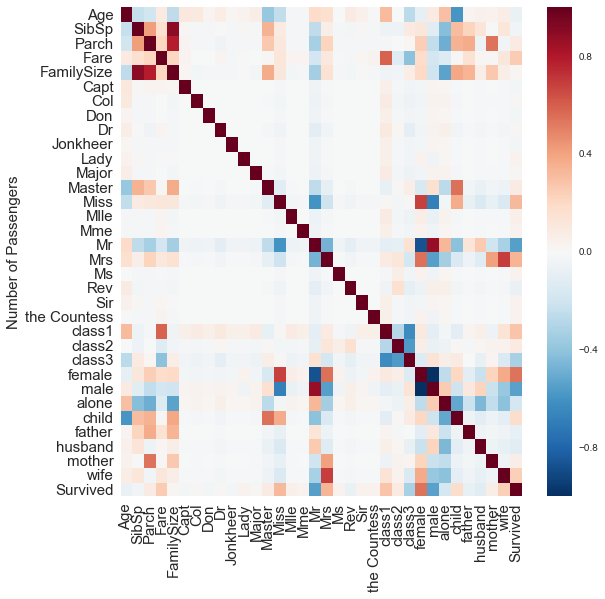

In [11]:
all_corr = titanic.corr()
all_corr.columns

import seaborn as sns

fig = plt.figure(figsize=(9,9))
sns.heatmap(all_corr, 
        xticklabels=list(all_corr.columns),
        yticklabels=list(all_corr.columns))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

Using all of the features generated There are several factors which appear to predict if a person will survive or not. In general, men did not fare well and were highly correlated with going down with the ship. Women and children also tended to survive. Furthermore, those who paid higher fair also made it off the ship.

In [12]:
# Save the labels on the side and drop it form the data frame
survive = titanic['Survived']
titanic = titanic.drop(['Survived'], axis=1)

# Convert to arrays
titanic = np.asarray(titanic)
survive = np.asarray(survive).reshape(len(survive), 1)



## Part 2: Decision Trees

... Because how can you take a course in Applied Machine Learning without fitting a decision tree?

### 2.1 Decision Tree
Using the basic [Decision Tree](http://scikit-learn.org/stable/modules/tree.html#tree) library in sklearn, fit a model to predict titanic survival. Make sure you come up with an appropriate way of handling each of the input variables before feeding them in to the decision tree. You can use the [DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) method to implement 10-fold cross-validation. Report the average training and testing accuracy across your 10 folds, and show a diagram of the tree (at least the first three levels).


In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

def cross_validate(clf, num_folds, X, Y):
    '''
        Simple cross-validation with no hyperpameter testing.
    '''
    k_fold = KFold(num_folds, shuffle=True, random_state = 56)
    results = np.zeros((2, num_folds+1))
    for k, (train, test) in enumerate(k_fold.split(X, Y)):
        clf = clf.fit(X[train], Y[train])
        train_predict = clf.predict(X[train])
        train_score = f1_score(train_predict, Y[train])
        test_predict = clf.predict(X[test])
        test_score = f1_score(test_predict, Y[test])
        results[:, k+1] = [train_score, test_score]

    results_df = pd.DataFrame(results)
    results_df.columns = [['set'] + ['fold '+str(i+1) for i in range(num_folds)]]
    results_df['set']=['Training Score', 'Test Score']
    results_df['average score'] = results_df.loc[:, 'fold 1':].mean(axis=1)

    return results_df, clf




In [14]:
from sklearn import tree

tree_clf = tree.DecisionTreeClassifier()
d_tree_10fold, tree_clf = cross_validate(tree_clf, 10, titanic, survive)
d_tree_10fold


,set,fold 1,fold 2,fold 3,fold 4,fold 5,fold 6,fold 7,fold 8,fold 9,fold 10,average score
0,Training Score,0.980645,0.978723,0.978862,0.978512,0.978224,0.975124,0.985366,0.976821,0.976974,0.979522,0.978877
1,Test Score,0.655738,0.705882,0.688525,0.790123,0.717949,0.794118,0.695652,0.606061,0.742857,0.784810,0.718171


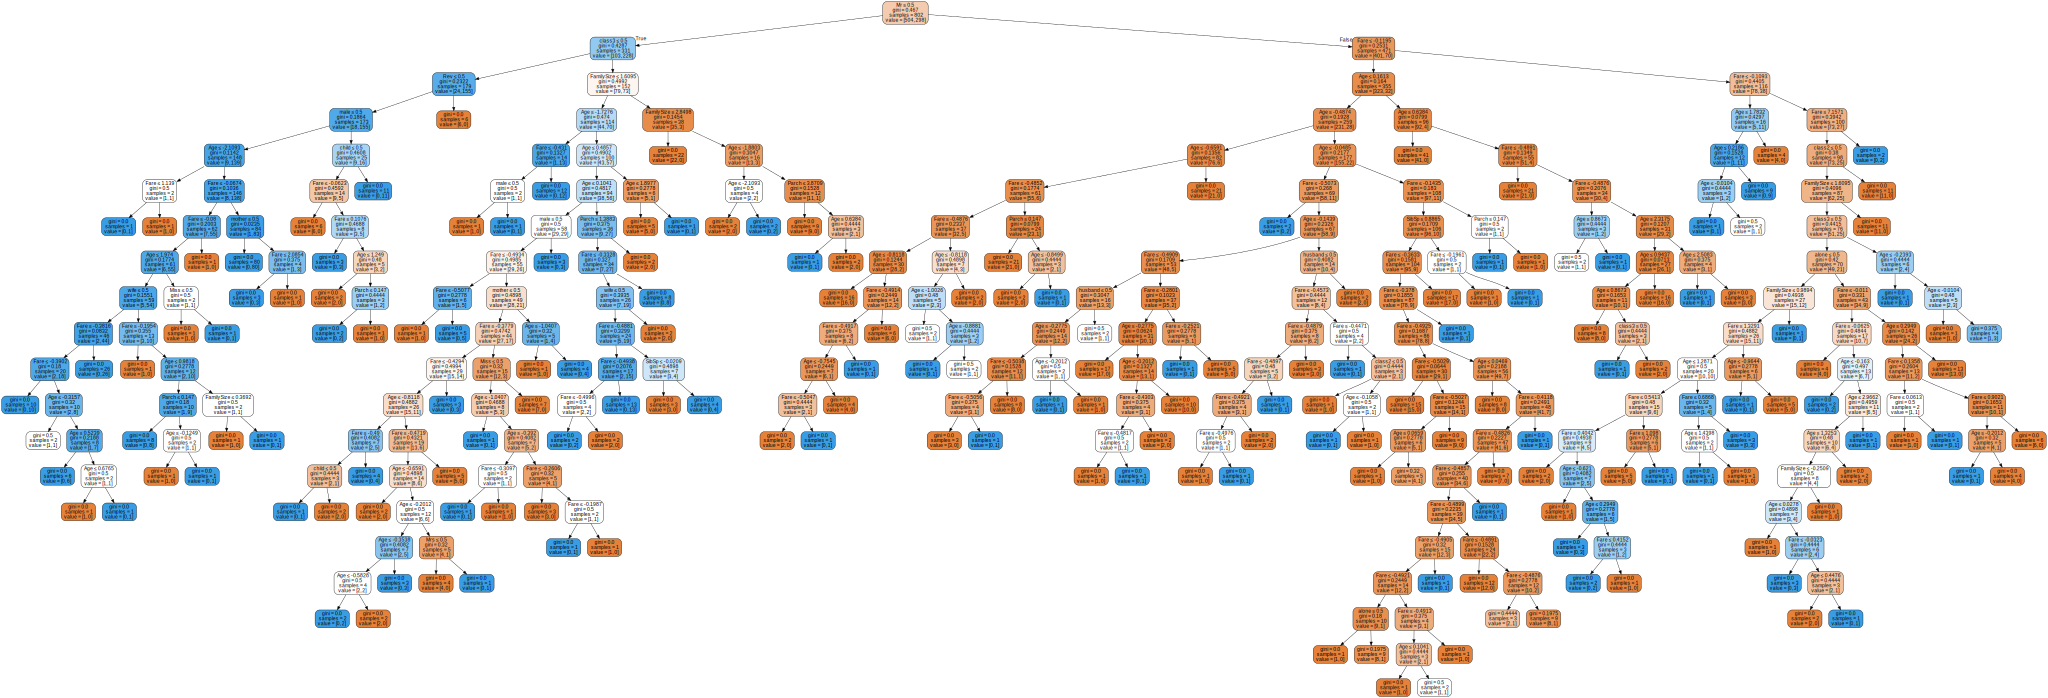

In [15]:
import graphviz 

dot_data = tree.export_graphviz(tree_clf, out_file=None) 
graph = graphviz.Source(dot_data)
dot_data = tree.export_graphviz(tree_clf, out_file=None, 
                         feature_names=feature_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graph 

Trees heavily overfit on their own training data, which is expected because the splits are based on the training data. The tree likes to split at "Mr". Following this, the class of the passenger and their fare paid heavily predicts survival. Overall, there are not that many features the tree uses. Mostly they are related to fare, age, sex, and familiy size.

### 2.2 Tree tuning

Use all of the data to re-fit a single decision tree with max_depth = 4 (i.e., no cross-validation). Show the tree diagram and also plot the feature importances. What do you observe?

In [16]:
# Concat together to shuffle to manually make some train/test data
tmp = np.concatenate((titanic, survive), axis = 1)
np.random.shuffle(tmp)
titanic_shuffled = tmp[:, :-1]
survive_shuffled = tmp[:, -1]


In [17]:
tree_4 = tree.DecisionTreeClassifier(max_depth=4, random_state=124)
tree_4 = tree_4.fit(titanic_shuffled, survive_shuffled)
train_predict = tree_4.predict(titanic_shuffled)
train_score = f1_score(train_predict, survive_shuffled)

train_score

0.7935103244837759

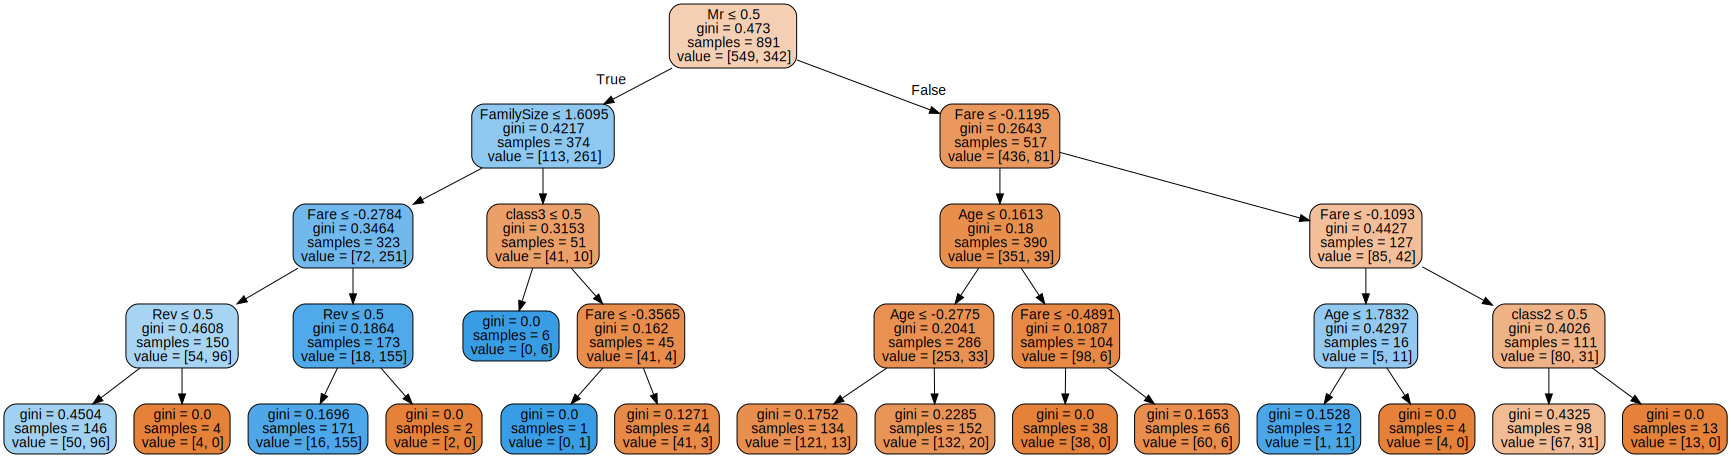

In [18]:
dot_data = tree.export_graphviz(tree_4, out_file=None) 
graph = graphviz.Source(dot_data)
dot_data = tree.export_graphviz(tree_4, out_file=None, 
                         feature_names=feature_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graph 

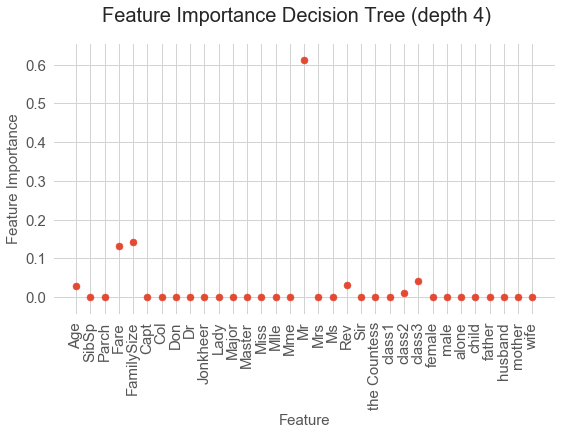

In [19]:
important_feats = pd.DataFrame((tree_4.feature_importances_))
important_feats['feature'] = feature_names
important_feats.columns = ['feat_importance', 'Feature']

fig = plt.figure(figsize=(9,5))
plt.style.use('ggplot')
ax = fig.gca()
ax.set_facecolor('white')
ax.grid(color='lightgray', linestyle='-', linewidth=1)

fig.suptitle('Feature Importance Decision Tree (depth 4)', fontsize = 20)

plt.scatter(range(len(important_feats['Feature'])), important_feats['feat_importance'])

plt.xticks(range(len(important_feats['Feature'])), important_feats['Feature'], fontsize=15, rotation = 'vertical')
plt.xlabel('Feature', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Feature Importance', fontsize=15)
plt.show()


The training score at a max depth of 4 is much lower than the cross-validated results. Therefore, an optimal depth does exist for trees.

We do see that the best split still occurs at the "Mr" feature though. The tree continues to pick out similar best features, but restricts it to primarily mr, fare, and family size. This is accurately reflected in the feature importance. Higher feature importance means the feature is found at a split closer to the root.

### 2.3 Sensitivity analysis
The built-in algorithm you are using has several parameters which you can tune. Using cross-validation, show how the choice of these parameters affects performance.

First, show how max_depth affects train and test accuracy. On a single axis, plot train and test accuracy as a function of max_depth. Use a red line to show test accuracy and a blue line to show train accuracy.

Second, show how test accuracy relates to both max_depth and min_samples_leaf. Specifically, create a 3-D plot where the x-axis is max_depth, the y-axis is min_samples_leaf, and the z-axis shows accuracy. What combination of max_depth and min-samples_leaf achieves the highest accuracy? How sensitive are the results to these two parameters?

In [93]:
max_depth = range(1, 30)
min_samples_leaf = range (1,21)

num_folds = 10
k_fold = KFold(num_folds, shuffle=True, random_state=56)

train_results = np.empty((0, num_folds+2), np.float32)
test_results = np.empty((0, num_folds+2), np.float32)
for d in max_depth:
    for l in min_samples_leaf:
        tree_depth = tree.DecisionTreeClassifier(max_depth=d, min_samples_leaf=l, random_state=124)
        train_tmp = []
        test_tmp = []
        for k, (train, test) in enumerate(k_fold.split(titanic, survive)):
            tree_depth = tree_depth.fit(titanic[train], survive[train])
            train_score = tree_depth.score(titanic[train], survive[train])
            test_score = tree_depth.score(titanic[test], survive[test])
            train_tmp.append(train_score)
            test_tmp.append(test_score)
        train_results = np.append(train_results, np.array([[d, l]+train_tmp]), axis=0)
        test_results = np.append(test_results, np.array([[d, l]+test_tmp]), axis=0)
        

tree_depthCV_train = pd.DataFrame(train_results)
tree_depthCV_train.columns = [['Depth', 'Min Leaf Samples'] + ['fold '+str(i+1) for i in range(num_folds)]]
tree_depthCV_train['average score'] = tree_depthCV_train.loc[:, 'fold 1':].mean(axis=1)

tree_depthCV_test = pd.DataFrame(test_results)
tree_depthCV_test.columns = [['Depth', 'Min Leaf Samples'] + ['fold '+str(i+1) for i in range(num_folds)]]
tree_depthCV_test['average score'] = tree_depthCV_test.loc[:, 'fold 1':].mean(axis=1)




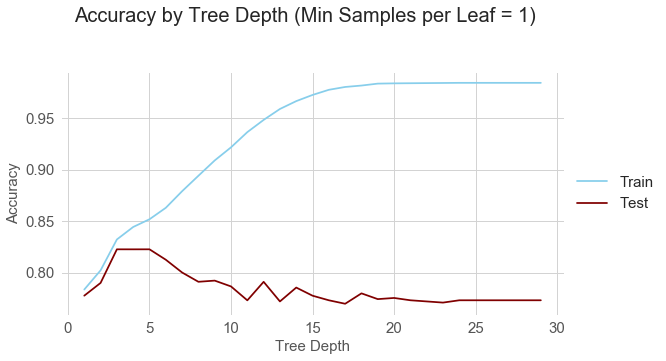

In [94]:
# Accuracy and tree depth
treeTrain_depthCV_1minsamp = tree_depthCV_train[tree_depthCV_train['Min Leaf Samples']==1.0]
treeTest_depthCV_1minsamp1 = tree_depthCV_test[tree_depthCV_test['Min Leaf Samples']==1.0]

fig = plt.figure(figsize=(9,5))
ax = fig.gca()
plt.style.use('ggplot')

fig.suptitle('Accuracy by Tree Depth (Min Samples per Leaf = 1)', fontsize = 20)

plt.plot(treeTrain_depthCV_1minsamp['Depth'], treeTrain_depthCV_1minsamp['average score'], color='skyblue', label = 'Train')
plt.plot(treeTest_depthCV_1minsamp1['Depth'], treeTest_depthCV_1minsamp1['average score'], color='maroon', label ='Test')

ax.set_facecolor('white')
ax.grid(color='lightgray', linestyle='-', linewidth=1)
plt.xlabel('Tree Depth', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)
plt.subplots_adjust(bottom = None, top = 0.8)
plt.show()


/Users/judyjinn/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


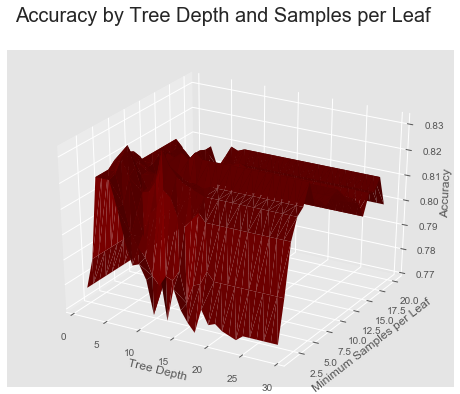

In [95]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
fig.suptitle('Accuracy by Tree Depth and Samples per Leaf', fontsize = 20)


train_x = tree_depthCV_train['Depth']
train_y = tree_depthCV_train['Min Leaf Samples']
train_z = tree_depthCV_train['average score']

test_x = tree_depthCV_test['Depth']
test_y = tree_depthCV_test['Min Leaf Samples']
test_z = tree_depthCV_test['average score']


# ax.scatter(train_x, train_y, train_z, zdir='z', color='skyblue', label = 'Train')
# ax.scatter(test_x, test_y, test_z, zdir='z', color='maroon', label ='Test')

# ax.plot_trisurf(train_x, train_y, train_z, color='skyblue')
ax.plot_trisurf(test_x, test_y, test_z, color='maroon')

ax.set_xlabel('Tree Depth')
ax.set_ylabel('Minimum Samples per Leaf')
ax.set_zlabel('Accuracy')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)
plt.subplots_adjust(bottom = 0.1)
plt.show()

There is a very clear optimal tree depth of 5 for the decision tree irrespective of the minimum samples per leaf. However, the accuracy for minimum samples per leaf changes depending on the depth of the tree and is highly variable. Sometimes there are multiple optimal minimums.

### 2.4 Logistic Regression, for comparison
Use a 10-fold cross-validated logistic regression predict survival. Make sure you come up with an appropriate way of handling each of the input variables before feeding them in to the regression. 
* How does the performance of this model compare to the decision tree?
* How do the coefficients from the logistic regression compare to the feature importances from the decision tree? Create a scatter plot that shows this relationship (one dot for each variable, y-axis is feature importance, x-axis is....?)

In [23]:
from sklearn import linear_model

survive = np.asarray(survive).reshape(len(survive),)

random_seed = 124
logreg = linear_model.LogisticRegression()
logreg_10fold, logreg = cross_validate(logreg, 10, titanic, survive)
logreg_10fold

,set,fold 1,fold 2,fold 3,fold 4,fold 5,fold 6,fold 7,fold 8,fold 9,fold 10,average score
0,Training Score,0.778146,0.772344,0.769231,0.756388,0.761092,0.763203,0.768719,0.77551,0.763514,0.759582,0.766773
1,Test Score,0.666667,0.750000,0.745763,0.845070,0.746269,0.821918,0.666667,0.62500,0.781250,0.800000,0.744860


In [24]:
important_feats = pd.DataFrame((tree_clf.feature_importances_))
important_feats['feature'] = feature_names
important_feats.columns = ['feat_importance', 'Feature']

logreg_coefs = pd.DataFrame(logreg.coef_)
logreg_coefs = logreg_coefs.transpose()
logreg_coefs['feature'] = feature_names
logreg_coefs.columns = ['coefficients', 'Feature']

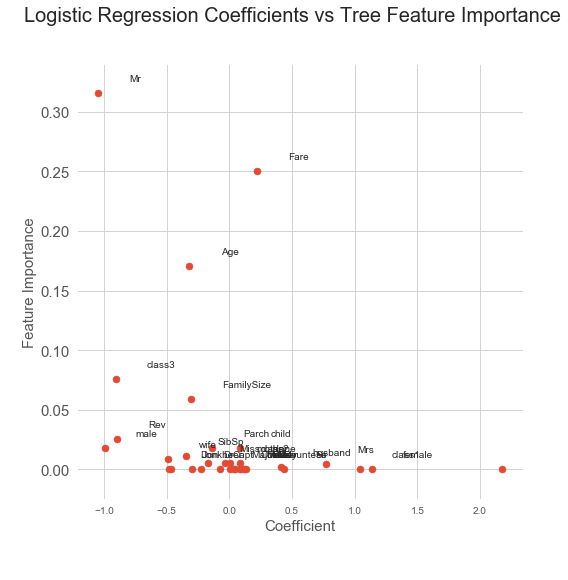

In [25]:
pretty_names = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']+titles+['class1', 'class2', 'class3',
                  'female', 'male', 'alone', 'child', 'father', 'husband', 'mother', 'wife']

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_facecolor('white')
ax.grid(color='lightgray', linestyle='-', linewidth=1)

fig.suptitle('Logistic Regression Coefficients vs Tree Feature Importance', fontsize = 20)

# plt.scatter(range(len(logreg_coefs['Feature'])), logreg_coefs['coefficients'], label = 'Logistic Regression \n Coefficients')
# plt.scatter(range(len(important_feats['Feature'])), important_feats['feat_importance'], label = 'Decision Tree \n Feature Importance')
plt.scatter(logreg_coefs['coefficients'],important_feats['feat_importance'])

for i, txt in enumerate(feature_names):
    ax.annotate(txt, (logreg_coefs['coefficients'][i]+0.25,important_feats['feat_importance'][i]+0.01))

# plt.xticks(range(len(logreg_coefs['Feature'])), logreg_coefs['feat_importance'], rotation='vertical', fontsize=15)
plt.xlabel('Coefficient', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Feature Importance', fontsize=15)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)
plt.show()

Although the training set does not do so well at predicting itself, it generalizes better to the test set. It is hard to say if there is a relationship between the feature importance and coefficients of the logistic regression although we would expect there to be. The only relationship I can see is that negative coefficients seem to be more related to feature importance. In general it may be that the two models are focusing on different features for prediction.

### 2.5 (Extra Credit): Implement a Decision Tree in Python

For extra credit, put away the canned algorithm from sklearn, and write your own decision tree algorithm. Use the simple recursive algorithm we described in class, and use your algorithm to re-do the analysis in 2.1. Do not worry about implementing bells and whistles. However, you will definitely need the following:
 * A "BuildTree" function that implements the recursive algorithm
 * A function to calculate information gain
 
For this problem, you can consult the internets to see how other have done this. However, you must make your code your own - do not plagiarize the examples of other peoples. Implement the minimum required code to build a decision tree

In [26]:
# Enter your code here

*Enter your observations here*

## Part 3: Putting together the pieces 

Over the past two months, you have learned the nuts and bolts of a large number of machine learning algorithms. This list includes: 
* Linear Regression
* Logistic Regression
* LASSO / Ridge Regression
* Support Vector Machines
* Nearest Neighbor
* k-Nearest Neighbors
* Naive Bayes
* Decision Trees
* Regression Trees
* Random Forests
* Boosted trees
* Perceptrons
* Neural Networks

Here, you will explore how well different algorithms can predict survival on the Titanic.


### 3.1 Horseraces

In addition to logistic regression and the single decision tree, use the following algorithms to predict survival: LASSO regression, k-Nearest Neighbors, [random forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), a [multi-layer perceptron](http://scikit-learn.org/stable/modules/neural_networks_supervised.html) and [Gradient Boosting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html). Make sure everything you do is carefully cross-validated, and that you are providing the same data to each algorithm, in a sensible way.

Create a barplot that shows how well each algorithm compares relative to the others, separately for the training and testing datsets. Define "performance" in the way you think is most appropriate for this problem, and justify that decision. What algorithm performs best?

*Note:* You might want to consider more than one measures of performance

In [27]:
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.neural_network import MLPClassifier # Multi-layer Perceptron
from sklearn.ensemble import GradientBoostingClassifier # Gradient Boosting


logreg_lasso = linear_model.LogisticRegression(penalty='l1')
logreg_lasso_10fold, logreg_lasso = cross_validate(logreg_lasso, 10, titanic, survive)
logreg_lasso_10fold

forest_clf = RandomForestClassifier()
forest_clf_10fold, knn_clf = cross_validate(forest_clf, 10, titanic, survive)

knn_clf = KNeighborsClassifier()
knn_clf_10fold, knn_clf = cross_validate(knn_clf, 10, titanic, survive)

mlp_clf = MLPClassifier()
mlp_clf_10fold, mlp_clf = cross_validate(mlp_clf, 10, titanic, survive)

gbc_clf = GradientBoostingClassifier()
gbc_clf_10fold, mlp_clf = cross_validate(gbc_clf, 10, titanic, survive)


In [28]:
models = pd.concat([logreg_lasso_10fold, forest_clf_10fold, knn_clf_10fold, mlp_clf_10fold, gbc_clf_10fold])
models['Model'] = (['Lasso']*2)+(['Random Forest']*2)+(['5 Nearest Neighbors']*2)+ \
    (['Multi-layer Perceptron']*2)+(['Gradient Boosting']*2)


m_train = models[models['set']=='Training Score']
m_test = models[models['set']=='Test Score']

models

,set,fold 1,fold 2,fold 3,fold 4,fold 5,fold 6,fold 7,fold 8,fold 9,fold 10,average score,Model
0,Training Score,0.770000,0.766610,0.764805,0.754717,0.762069,0.756849,0.772575,0.770798,0.763203,0.761404,0.764303,Lasso
1,Test Score,0.690909,0.761905,0.745763,0.845070,0.782609,0.821918,0.666667,0.634921,0.781250,0.800000,0.753101,Lasso
0,Training Score,0.951140,0.952066,0.952381,0.948074,0.957699,0.944162,0.975610,0.956811,0.958814,0.955479,0.955224,Random Forest
1,Test Score,0.523077,0.774194,0.771930,0.775000,0.760563,0.764706,0.709677,0.718750,0.750000,0.825000,0.737290,Random Forest
0,Training Score,0.815409,0.819237,0.807190,0.804636,0.807496,0.807309,0.819835,0.806612,0.811980,0.812925,0.811263,5 Nearest Neighbors
1,Test Score,0.631579,0.738462,0.689655,0.816901,0.704225,0.794118,0.724138,0.746269,0.764706,0.780488,0.739054,5 Nearest Neighbors
0,Training Score,0.781609,0.766667,0.772344,0.736842,0.716763,0.765599,0.771574,0.781302,0.763025,0.767318,0.762304,Multi-layer Perceptron
1,Test Score,0.654545,0.761905,0.745763,0.828571,0.677419,0.810811,0.736842,0.646154,0.818182,0.800000,0.748019,Multi-layer Perceptron
0,Training Score,0.869565,0.853782,0.868243,0.860068,0.866438,0.868243,0.869270,0.856198,0.854730,0.861111,0.862765,Gradient Boosting
1,Test Score,0.629630,0.741935,0.700000,0.849315,0.794521,0.805970,0.758621,0.727273,0.823529,0.779221,0.761001,Gradient Boosting


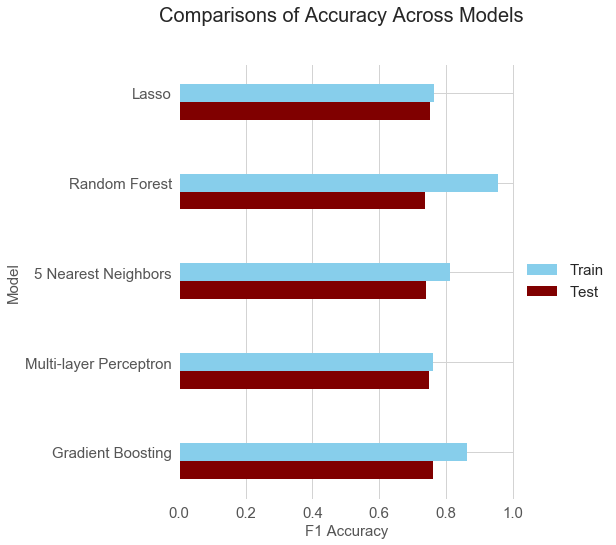

In [29]:
# Bar Graph Comparisons
fig = plt.figure(figsize=(6,8))
ax = fig.gca()
ax.set_facecolor('white')
ax.grid(color='lightgray', linestyle='-', linewidth=1)

fig.suptitle('Comparisons of Accuracy Across Models', fontsize = 20)


ypos = np.arange(len(m_train))
bar_height = 0.2
ax.barh(ypos, m_train['average score'], height = bar_height, label = 'Train', color ='skyblue')
ax.barh(ypos+bar_height, m_test['average score'], height = bar_height, label = 'Test', color='maroon')

ax.set_yticks(ypos)
ax.set_yticklabels(['Lasso','Random Forest','5 Nearest Neighbors',
                    'Multi-layer Perceptron','Gradient Boosting'], fontsize = 15)
plt.ylabel('Model', fontsize=15)
ax.invert_yaxis()  # labels read top-to-bottom
plt.xticks(fontsize=15)
plt.xlabel('F1 Accuracy', fontsize=15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)
plt.show()




Above is a comparison of multiple models' prediction accuracy on the training data and test data. In general, many of them perform equally well when using the out of the box defaults, averaging around 75% accuracy. I chose to use an F1 score for reporting accuracy. This is becuase I noticed that survivors were in the minority. Thus, by chance, it would have been highly likely to guess a passenger died and do well on an overall score. Instead, thie F1 score penalizes false negatives and reports are more balanced score.

### 3.2 Error analysis

Perform some error analysis to gain some intuition for where your models are not performing well. Are your models all having problems with the same individuals? Inspect this manually and report your results.

Now, do this a bit more systematically by creating a correlation matrix showing the correlation in predictions between each model. In other words, treat the output of each of your *M* models as a binary vector with one entry for each of the test data, and show how these prediction vectors relate to each other by plotting the *M* x *M* matrix of correlation coefficients. What do you observe?

In [38]:
# Part 1) Get true labels and create vectors of the predicted results from all of the algorithms.
# Are there some instances in which all of the models are performing poorly? Why?

# Run all classifiers on full set to get predicted labels
predictions = np.empty((len(survive), 0), np.float32)

logreg_lasso = linear_model.LogisticRegression(penalty='l1')
logreg_lasso = logreg_lasso.fit(titanic, survive)
logreg_lasso_predict = logreg_lasso.predict(titanic).reshape(len(survive),1)
predictions = np.append(predictions, logreg_lasso_predict, axis=1)


forest_clf = RandomForestClassifier()
forest_clf = forest_clf.fit(titanic, survive)
forest_predict = forest_clf.predict(titanic).reshape(len(survive),1)
predictions = np.append(predictions, forest_predict, axis=1)


knn_clf = KNeighborsClassifier()
knn_clf = knn_clf.fit(titanic, survive)
knn_clf_predict = knn_clf.predict(titanic).reshape(len(survive),1)
predictions = np.append(predictions, knn_clf_predict, axis=1)

mlp_clf = MLPClassifier()
mlp_clf = mlp_clf.fit(titanic, survive)
mlp_clf_predict = mlp_clf.predict(titanic).reshape(len(survive),1)
predictions = np.append(predictions, mlp_clf_predict, axis=1)


gbc_clf = GradientBoostingClassifier()
gbc_clf = gbc_clf.fit(titanic, survive)
gbc_clf_predict = gbc_clf.predict(titanic).reshape(len(survive),1)
predictions = np.append(predictions, gbc_clf_predict, axis=1)

ensemble = predictions

predictions = np.append(predictions, survive.reshape(len(survive),1), axis=1)
predictions = pd.DataFrame(predictions)


predictions.columns = ['Lasso','Random Forest','5 Nearest Neighbors',
                    'Multi-layer Perceptron','Gradient Boosting', 'True Survival']



In [39]:
def wrong(data):
    correct = data['True Survival']
    wrong = (data[['Lasso', 'Random Forest', '5 Nearest Neighbors',
                     'Multi-layer Perceptron','Gradient Boosting']] != correct).sum()
    return wrong
    
predictions['tot_wrong'] = predictions.apply(wrong, axis=1)



In [40]:
predictions = predictions.reset_index()
predictions
predictions.columns = ['Instance number', 'Lasso', 'Random Forest', '5 Nearest Neighbors',
                     'Multi-layer Perceptron','Gradient Boosting', 'True Survival', 'tot_wrong']
predictions = predictions.sort_values('tot_wrong', ascending=False)
predictions.to_csv('predictions.csv', index=False)



In [52]:
worst = predictions[predictions['tot_wrong']==5]
bad_passengers = worst.reset_index()['index']
reference.loc[bad_passengers]

,LastName,FirstName,Title,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,family,Survived
505,Mamee,Hanna,Mr,3,male,0.142,-0.475,-0.474,2677,-0.503,C,-0.561,alone,1
518,McCoy,Bernard,Mr,3,male,0.142,1.340,-0.474,367226,-0.180,Q,0.679,alone,1
388,Isham,Ann Elizabeth,Miss,1,female,1.516,-0.475,-0.474,PC 17595,-0.070,C,-0.561,alone,0
356,Henry,Delia,Miss,3,female,0.142,-0.475,-0.474,382649,-0.492,Q,-0.561,alone,0
62,Barah,Hanna Assi,Mr,3,male,-0.774,-0.475,-0.474,2663,-0.503,C,-0.561,alone,1
416,Jonsson,Carl,Mr,3,male,0.142,-0.475,-0.474,350417,-0.490,S,-0.561,alone,1
419,Jussila,Eiriik,Mr,3,male,0.142,-0.475,-0.474,STON/O 2. 3101286,-0.489,S,-0.561,alone,1
864,Wilhelms,Charles,Mr,2,male,0.066,-0.475,-0.474,244270,-0.387,S,-0.561,alone,1
559,Moss,Albert Johan,Mr,3,male,0.142,-0.475,-0.474,312991,-0.492,S,-0.561,alone,1
80,Beesley,Lawrence,Mr,2,male,0.295,-0.475,-0.474,248698,-0.387,S,-0.561,alone,1


Part 1) Yes with a manual inspection, there are some passengers where all five models perform poorly. They are seen above. In general, they are men who survived but travelled alone. They were also lower class passengers. The women who died were all young girls, but they too were traveling alone. The models tend to predict that women survive and men die, thus these anomolies stumped all of the algorithms.

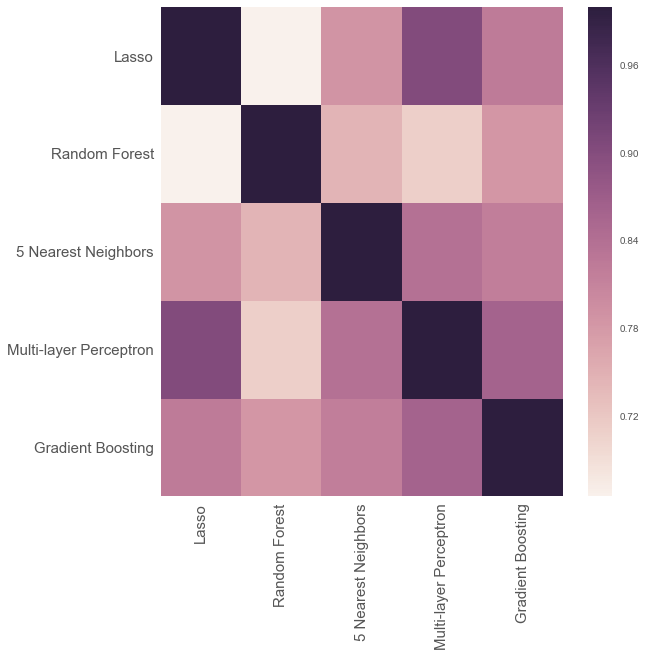

In [56]:
# Part 2) Using just the predicted labels, use .corr() and compare all of them against each other.
# Do some show correlations with others? 

pd.set_option('display.float_format', lambda x: '%.3f' % x)

predictions_corr = predictions[['Lasso', 'Random Forest', '5 Nearest Neighbors',
                     'Multi-layer Perceptron','Gradient Boosting']].corr()

fig = plt.figure(figsize=(9,9))
sns.heatmap(predictions_corr, 
        xticklabels=list(predictions_corr.columns),
        yticklabels=list(predictions_corr.columns))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation = 'vertical')
plt.show()

In general, many of the models are correlated with the Gradient Boosting method. The MLP and Lasso also are very strongly correlated. The random forest appears to be on its own in terms of predicting labels. Interestingly, it does quite well, but is likely picking different features to predict with. This supports our prior plot showing the logistic regression coefficients and decision tree feature importance. There seemed to be no correlation despite both of them doing equally well.

### 3.3 Develop an ensemble

Create an ensemble learner by hand. Using all of the training data, fit each of the models in 3.1. Then, classify each instance in the test data by taking the majority vote of all of your different fitted models. How accurately do you predict survival? How does this compare to your earlier results? 

*Note:* You will have to decide how to handle tie votes

In [34]:
# Using all the predicted vectors again, make a vote across all of them and classify the data this way.
# How does this voted, ensemble result compare to the true labels?

ensemble = pd.DataFrame(ensemble)

ensemble.columns = ['Lasso', 'Random Forest', '5 Nearest Neighbors',
                     'Multi-layer Perceptron','Gradient Boosting']

def vote(data):
    if data['tied_values']==1:
        vote = data['this']
        return vote
    else:
        return np.nan

ensemble_mode = ensemble.mode(axis = 1)
ensemble_mode = ensemble_mode.rename(columns={ensemble_mode.columns[0]: "this" })
ensemble_mode['tied_values'] = ensemble_mode.count(axis=1)
ensemble_mode

ensemble['vote'] = ensemble_mode.apply(vote, axis=1)

ensemble_score = f1_score(ensemble['vote'], survive)
print('Ensemble F1 accuracy is:', ensemble_score)


Ensemble F1 accuracy is: 0.823529411765


My ensemble method performs better than all of my models independently. I would guess this is because of factors we saw from the correlation method. Some models are better at predicting outcomes using different features than other models. When aggregated, they are able to capture the nuances that other models could not pick up alone.

### 3.4 What can we learn from the models?

Revisit your analysis from in part 1.2, now that you have deployed several machine learning models on the task of predicting survival. For each of the models that you fitted in 3.1, do your best to interpret the model itself, and summarize what the model tells you about the factors that were most important in determining survival on the Titanic. Are all of the models telling you the same thing, or do different models suggest different explanations?

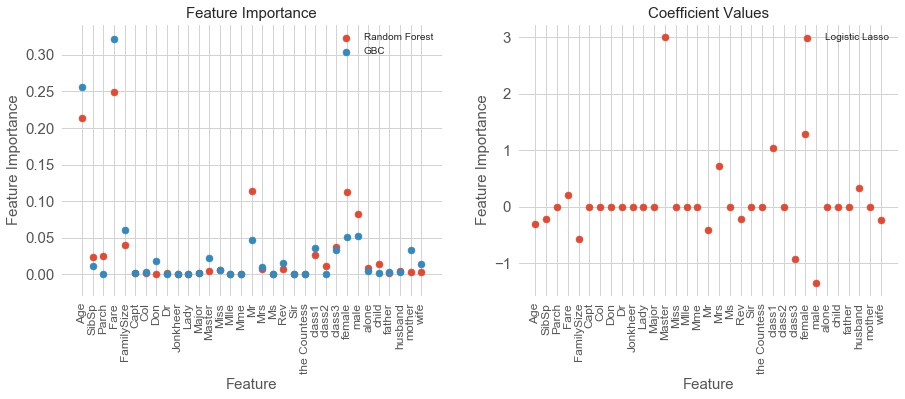

In [182]:
feature_names

forest_clf.feature_importances_
gbc_clf.feature_importances_
logreg_lasso.coef_[0]


from matplotlib import gridspec

fig = plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], height_ratios=[1])
# fig.suptitle('Feature Importance Decision Tree (depth 4)', fontsize = 20)

ax0 = plt.subplot(gs[0])
ax0.set_facecolor('white')
ax0.grid(color='lightgray', linestyle='-', linewidth=1)
ax0.set_title('Feature Importance', fontsize=15)

ax0.scatter(range(len(important_feats['Feature'])), forest_clf.feature_importances_, label = 'Random Forest')
ax0.scatter(range(len(important_feats['Feature'])), gbc_clf.feature_importances_, label = 'GBC')

plt.xticks(range(len(important_feats['Feature'])), important_feats['Feature'], fontsize=12, rotation = 'vertical')
plt.xlabel('Feature', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Feature Importance', fontsize=15)
ax0.legend(loc='upper right', fontsize=10)

# ---

ax1 = plt.subplot(gs[1])
ax1.set_facecolor('white')
ax1.grid(color='lightgray', linestyle='-', linewidth=1)
ax1.set_title('Coefficient Values', fontsize=15)

ax1.scatter(range(len(important_feats['Feature'])), logreg_lasso.coef_[0], label = 'Logistic Lasso')

plt.xticks(range(len(important_feats['Feature'])), important_feats['Feature'], fontsize=12, rotation = 'vertical')
plt.xlabel('Feature', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Feature Importance', fontsize=15)

ax1.legend(loc='upper right', fontsize=10, facecolor='white')

plt.show()



In the figure above, on the left are the feature importance values for a random forest and a gradient boosting classifier. The two share similarities when giving importance to features. This makes sense because a GBC is made by acting on weak trees and "boosting" poor performance on particular instances where are misclassified. Ultimately both a random forest and a GBC should pick similar features that are strongly predictive of the labels. The difference between the two is that the GBC picks up extra features which help it predict labels. In particular, it picked out 'Don', 'Master', and 'mother' as features which may be helpful. In general though, both agree that Age and Fare paid, were strong predictors of survival. Interestingly, the GBC did not predict 'Mr' and  'male' and 'female' would be as strong of a predictor for survival as did the random forest.

The lasso-regularized logistic regression picked rather different features. It agreed with the the random forest that being 'female' and 'male' are both highly predictive of survival with 'male' having a negative impact on survival and being 'female' as importnat. In addition, married women ('Mrs') Also did well, as was being a son ('Master') which seems to be one of the most significant factors of survival according to the Logistic model. Interestingly, family size appeared to have a negative impact on survival

In [183]:
print(knn_clf.get_params())


{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


Perhaps less interesting and harder to explain is the K nearest neighbors model. It simply takes the test features and finds the 5 training instances which are the closest. It then assigns the most popular value to the test data set. It really says nothing about which features are most important.

In [190]:
print(mlp_clf.n_layers_)


3
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


Pretty hard to explain the MLP. It only had 3 layers, but it looks like it had nearly 99 nodes in the layers. At some point it finished its iterations and settled on algorithm, but what weights it assigned to each node and what features those nodes were is hard to assess and understand.

## Submission to Kaggle
Highest: 62%

In [35]:
path = os.getcwd() 

# assign types to save memory
test = pd.read_csv(path+'/test.csv', dtype={
        'PassengerId': np.uint16, 
        'Survived': np.uint8,
        'Pclass': 'category', 
        'Name': 'category', 
        'Sex': 'category', 
        'Age': np.float32, 
        'SibSp': np.uint8, 
        'Parch': np.uint8, 
        'Ticket': 'category', 
        'Fare': np.float32,
        'Cabin': 'category',
        'Embarked': 'category'
        })
ID = test['PassengerId']

# Create more features

# Create first, last, title names
test = test.sort_values('Name').reset_index()
test['LastName'], test['FirstName'] = test['Name'].str.split(',', 1).str
test['Title'], test['FirstName'] = test['FirstName'].str.split('.', 1).str

# Create family sizes
test['FamilySize']=test['SibSp']+test['Parch']+1

# Fill in missing ages
avgby_family = test.groupby(['LastName','FamilySize', 'Title']).mean().reset_index()
avgby_title = test.groupby('Title').mean().reset_index()

# Guess age by checking for a family. If there's a family then be close to the age of those that share a title
# Otherwise set age to be the average age of those with the same title
def guess_age(data):
    if np.isnan(data['Age']):
        title = data['Title']
        lastname = data['LastName']
        familysize = data['FamilySize']
        age = avgby_family[(avgby_family['LastName']==lastname) & (avgby_family['FamilySize']==familysize)]['Age'].iloc[0]
        if np.isnan(age):
            age = np.round(avgby_title[avgby_title['Title']==' Mr']['Age'].iloc[0])
            return age
        else:
            return age 
    else:
        return data['Age']
test['Age'] = test.apply(guess_age, axis=1) 

# Label as mother, father, wife (no kids), husband (no kids), child, or traveling alone
def mother_father(data):
    if (data['Title']==' Mr') and (data['Parch'] > 1):
        return 'father'
    elif (data['Title']==' Mrs') and (data['Parch'] > 1):
        return 'mother'
    if (data['Title']==' Mr') and (data['SibSp'] == 1):
        return 'husband'
    elif (data['Title']==' Mrs') and (data['SibSp'] == 1):
        return 'wife'
    elif ((data['Title']==' Master') or (data['Title']==' Miss')) and (data['Age'] <= 18.0):
        return 'child'
    else:
        return 'alone'
test['family'] = test.apply(mother_father, axis=1)

# Most commonly embarked port was S, replace the two missing values
test['Embarked'].value_counts()
test['Embarked'] = test['Embarked'].fillna('S')

# Drop unwanted columns
test = test[['LastName', 'FirstName', 'Title', 'Pclass', 'Sex', 'Age', 'SibSp','Parch',
                   'Ticket', 'Fare', 'Embarked','FamilySize', 'family']]

# Clean up data. One hot all categorical features.

test['Age'] = standardize(test['Age'])
test['SibSp'] = standardize(test['SibSp'])
test['Parch'] = standardize(test['Parch'])
test['Fare'] =  standardize(test['Fare'])
test['FamilySize'] =  standardize(test['FamilySize'])

# clean up white spaces in the names (not that it matters), take only the instances with more than 2 occurrences
test['Title'] = test['Title'].str.strip()
titles = list(test['Title'].unique())

# one hot encode the titles
test = pd.concat([test, pd.get_dummies(test['Title'])], axis=1)
# One hot encode all other categories.
test = pd.concat([test, pd.get_dummies(test['Pclass'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['Sex'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['family'])], axis=1)

test = test.drop(['Title', 'Pclass', 'Sex', 'family', 'LastName', 
                        'FirstName', 'Ticket', 'Embarked'], axis=1)

test.columns = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']+titles+['class1', 'class2', 'class3',
                  'female', 'male', 'alone', 'child', 'father', 'husband', 'mother', 'wife']

feature_names2 = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']+titles+['class1', 'class2', 'class3',
                  'female', 'male', 'alone', 'child', 'father', 'husband', 'mother', 'wife']
tmp = feature_names
tmp2 = list(feature_names2)
tmp3 = list(set(tmp)-set(tmp2))
for name in tmp3:
    test[name] = 0

test = test[feature_names]

nan_index = test['Fare'].index[test['Fare'].apply(np.isnan)]
test['Fare'][nan_index] = test['Fare'].mean()

# test = test.sample(frac=1).reset_index(drop=True)
test.head(5)


# Convert to arrays
test = np.asarray(test)

# Run all classifiers on full set to get predicted labels
predictions = np.empty((len(ID), 0), np.float32)

logreg_lasso = linear_model.LogisticRegression(penalty='l1')
logreg_lasso = logreg_lasso.fit(titanic, survive)
logreg_lasso_predict = logreg_lasso.predict(test).reshape(len(ID),1)
predictions = np.append(predictions, logreg_lasso_predict, axis=1)

forest_clf = RandomForestClassifier()
forest_clf = forest_clf.fit(titanic, survive)
forest_predict = forest_clf.predict(test).reshape(len(ID),1)
predictions = np.append(predictions, forest_predict, axis=1)


knn_clf = KNeighborsClassifier()
knn_clf = knn_clf.fit(titanic, survive)
knn_clf_predict = knn_clf.predict(test).reshape(len(ID),1)
predictions = np.append(predictions, knn_clf_predict, axis=1)

mlp_clf = MLPClassifier()
mlp_clf = mlp_clf.fit(titanic, survive)
mlp_clf_predict = mlp_clf.predict(test).reshape(len(ID),1)
predictions = np.append(predictions, mlp_clf_predict, axis=1)


gbc_clf = GradientBoostingClassifier()
gbc_clf = gbc_clf.fit(titanic, survive)
gbc_clf_predict = gbc_clf.predict(test).reshape(len(ID),1)
predictions = np.append(predictions, gbc_clf_predict, axis=1)

ensemble = predictions

predictions = pd.DataFrame(predictions)
predictions.columns = ['Lasso','Random Forest','5 Nearest Neighbors',
                    'Multi-layer Perceptron','Gradient Boosting']

predictions


ensemble = pd.DataFrame(ensemble)

ensemble.columns = ['Lasso', 'Random Forest', '5 Nearest Neighbors',
                     'Multi-layer Perceptron','Gradient Boosting']

def vote(data):
    if data['tied_values']==1:
        vote = data['this']
        return vote
    else:
        return np.nan

ensemble_mode = ensemble.mode(axis = 1)
ensemble_mode = ensemble_mode.rename(columns={ensemble_mode.columns[0]: "this" })
ensemble_mode['tied_values'] = ensemble_mode.count(axis=1)
ensemble_mode

ensemble['vote'] = ensemble_mode.apply(vote, axis=1)

ID = ID.reshape(418,1)
vote = np.asarray(ensemble['vote']).reshape(418,1)
submit = np.concatenate((ID, vote), axis=1)
submit = pd.DataFrame(submit)
submit.columns = ['PassengerId', 'Survived']

submit['Survived'] = submit['Survived'].fillna(submit['Survived'].mode()[0])
submit = submit.astype(int)
submit = submit.sort_values(by='PassengerId')
submit.to_csv('submit.csv', index=False)

/Users/judyjinn/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/judyjinn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:178: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
